### Model Training & Discrimination

In this notebook we take our three cleaned datasets (`dfA`, `dfB_filled`, `dfC_filled`) and:

1. **Define pipelines** for our two classifier families:
   - L1‐regularized **Logistic Regression**
   - **Random Forest** with class balancing

2. **Compare discrimination** via **stratified 5-fold cross-validation** using the **ROC-AUC** metric:
   - Evaluate mean ± std AUC for each model (LR & RF) on each trial dataset (A, B, C)
   - Visualize as a bar chart to identify the best missing-value strategy

3. **Hyperparameter tuning** on the top-performing trial:
   - Use `GridSearchCV` to optimize key parameters (`C` and penalty for LR; `n_estimators`, `max_depth`, `max_features` for RF)
   - Report best CV-AUC and selected parameters

4. **Final hold-out evaluation**:
   - Split the chosen trial dataset into a train/test set (e.g. 80/20 stratified)
   - Fit the tuned pipelines on the training portion
   - Compute **hold-out ROC curve** and **ROC-AUC** on the test set
   - Report additional metrics (accuracy, sensitivity, specificity) at a default 0.5 threshold 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# — Pipelines & Preprocessing —
from sklearn.pipeline       import Pipeline
from sklearn.preprocessing  import StandardScaler
from sklearn.impute         import SimpleImputer, KNNImputer

# — Classifiers —
from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import RandomForestClassifier

# — Model Selection & CV —
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split

# — Metrics & ROC/AUC —
from sklearn.metrics         import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve, average_precision_score


In [11]:
# Load Original Dataframe
df = pd.read_csv('diabetes.csv')

In [12]:
# Define Columns
missing_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

feature_cols = [
    'Pregnancies','Glucose','BloodPressure',
    'SkinThickness','Insulin','BMI',
    'DiabetesPedigreeFunction','Age'
]

target_col = 'Outcome'

In [13]:
# Create Dataframes for each individual trial

# Trial A: drop zeros in missing_cols
dfA_mask = ~(df[missing_cols] == 0).any(axis=1)
dfA = df.loc[dfA_mask, feature_cols + [target_col]].reset_index(drop=True)

# Trial B: median impute zeros->NaN on feature_cols
dfB_filled = df.copy()
dfB_filled[missing_cols] = dfB_filled[missing_cols].replace(0, np.nan)
med_imp = SimpleImputer(strategy='median') 
dfB_filled[feature_cols] = med_imp.fit_transform(dfB_filled[feature_cols])

# Trial C: KNN impute zeros->NaN on feature_cols
dfC_filled = dfB_filled.copy()
knn_imp = KNNImputer(n_neighbors=5)
dfC_filled[feature_cols] = knn_imp.fit_transform(dfC_filled[feature_cols])

### Performing Cross-validation on all Trial Dataframes to Find Best-Fit Models

In [14]:
# Define Model Pipelines
def make_pipe(clf):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

models = {
    'Logistic': make_pipe(LogisticRegression(solver='liblinear')),
    'RandomForest': make_pipe(RandomForestClassifier(
                        class_weight='balanced', random_state=0))
}

# Cross-Validated ROC-AUC on each trial
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
for trial_name, df_t in [
    ('A: drop zeros', dfA),
    ('B: median imp.', dfB_filled),
    ('C: KNN imp.', dfC_filled),
]:
    X_t = df_t[feature_cols]
    y_t = df_t['Outcome']
    for model_name, pipe in models.items():
        scores = cross_val_score(
            pipe, X_t, y_t,
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1
        )
        results.append({
            'Trial': trial_name,
            'Model': model_name,
            'Mean AUC': scores.mean(),
            'Std AUC': scores.std()
        })

cv_results = pd.DataFrame(results)
print(cv_results)

            Trial         Model  Mean AUC   Std AUC
0   A: drop zeros      Logistic  0.850254  0.020409
1   A: drop zeros  RandomForest  0.865524  0.021687
2  B: median imp.      Logistic  0.836478  0.020355
3  B: median imp.  RandomForest  0.825187  0.020057
4     C: KNN imp.      Logistic  0.836478  0.020355
5     C: KNN imp.  RandomForest  0.825187  0.020057


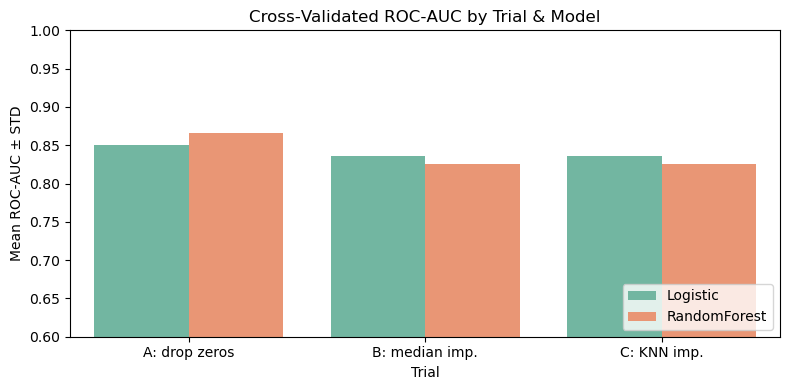

In [15]:
# Create BarChart of CV AUC
plt.figure(figsize=(8,4))
sns.barplot(
    data=cv_results,
    x='Trial', y='Mean AUC', hue='Model',
    capsize=0.1, errwidth=1, palette='Set2'
)
plt.ylim(0.6,1.0)
plt.title('Cross‑Validated ROC‑AUC by Trial & Model')
plt.ylabel('Mean ROC‑AUC ± STD')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Conclusions & Next Steps

From our stratified 5-fold CV results:

- **Trial A (drop-zeros)** delivered the highest mean ROC-AUC for both Logistic Regression (≈ 0.85) and Random Forest (≈ 0.87).  
- **Trial B (median imputation)** and **Trial C (KNN imputation)** performed similarly to each other, but both trailed Trial A by a few points (≈ 0.84 vs. 0.85 for LR; ≈ 0.83 vs. 0.87 for RF).

**Direction moving forward:**

1. **Hyperparameter tuning on Trial A**  
   Since it exhibits the strongest baseline discrimination, optimizing its model parameters is likely to yield the best final performance on our (small) dataset.

2. **Hyperparameter tuning on Trial C**  
   Although Trial A exhibits the highest discrimination scores currently, we expect that with more data—as would be the case in a larger clinical study—**KNN imputation** would better preserve complex feature relationships than simple median fills. Tuning on Trial C lets us assess whether an imputation-based workflow can match or even surpass the “drop-zeros” strategy once fully optimized.

In the next section, we will run `GridSearchCV` on both Trial A and Trial C pipelines to find their optimal hyperparameters and compare their tuned CV-AUC scores.  

In [16]:
# Hyperparameter tuning for Trial A (Dropped-Zeros DataFrame)

pipeA = Pipeline([
    ('imputer', 'passthrough'),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear'))
])

# Tuning Logistic Regression on dfA
param_grid_lr = {
    'clf__C': [0.01,0.1,1,10,100], 
    'clf__penalty':['l1','l2']
}

gsA_lr = GridSearchCV(
    pipeA, 
    param_grid_lr, 
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=1
)
gsA_lr.fit(dfA[feature_cols], dfA['Outcome'])
print("Trial A Best LR params:", gsA_lr.best_params_) 
print("Trial A Best LR CV-AUC:", gsA_lr.best_score_)

# Tuning Random Forest on dfA
pipeA_rf = pipeA.set_params(clf=RandomForestClassifier(class_weight='balanced', random_state=0))
param_grid_rf = {
    'clf__n_estimators': [100,200,500],
    'clf__max_depth': [None,5,10,20],
    'clf__max_features': ['sqrt','log2']
}
gsA_rf = GridSearchCV(
    pipeA_rf, 
    param_grid_rf, 
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=1
)
gsA_rf.fit(dfA[feature_cols], dfA['Outcome'])
print("Trial A Best RF params:", gsA_rf.best_params_)
print("Trial A Best RF CV-AUC:", gsA_rf.best_score_)

Trial A Best LR params: {'clf__C': 1, 'clf__penalty': 'l1'}
Trial A Best LR CV-AUC: 0.8517332812325555
Trial A Best RF params: {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__n_estimators': 200}
Trial A Best RF CV-AUC: 0.8676747236798036


In [17]:
# Hyperparameter tuning for Trial C (KNN-Imputed DataFrame)

pipeC = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear'))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2']
}

gs_lr = GridSearchCV(
    pipeC.set_params(clf=LogisticRegression(solver='liblinear')),
    param_grid_lr,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
gs_lr.fit(dfC_filled[feature_cols], dfC_filled['Outcome'])
print("Trial C Best LR params:", gs_lr.best_params_)
print("Trial C Best LR CV-AUC:", gs_lr.best_score_)

# Tune RandomForestClassifier on KNN-imputed data
param_grid_rf = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__max_features': ['sqrt', 'log2']
}
gs_rf = GridSearchCV(
    pipeC.set_params(clf=RandomForestClassifier(class_weight='balanced', random_state=0)),
    param_grid_rf,
    cv=cv,
    scoring='roc_auc',
    n_jobs=1
)
gs_rf.fit(dfC_filled[feature_cols], dfC_filled['Outcome'])
print("Trial C Best RF params:", gs_rf.best_params_)
print("Trial C Best RF CV-AUC:", gs_rf.best_score_)

Trial C Best LR params: {'clf__C': 0.1, 'clf__penalty': 'l1'}
Trial C Best LR CV-AUC: 0.8381788958770091
Trial C Best RF params: {'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__n_estimators': 100}
Trial C Best RF CV-AUC: 0.8387204751921733


### Trial A Tuned Model and ROC-AUC Curve

In [32]:
# Set up model to include best parameters

# Split dfA
X = dfA[feature_cols]
y = dfA['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

bestA_lr = Pipeline([
    ('imputer', 'passthrough'),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
                C=1, 
                penalty='l1', 
                solver='liblinear',
                class_weight='balanced',
                random_state=0))
])

bestA_rf = Pipeline([
    ('imputer', 'passthrough'),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                max_features='sqrt',
                class_weight='balanced',
                random_state=0))
])

# Fit on training data
bestA_lr.fit(X_train, y_train)
bestA_rf.fit(X_train, y_train)

# Predictions and Probabilities
probsA_lr = bestA_lr.predict_proba(X_test)[:,1]
probsA_rf = bestA_rf.predict_proba(X_test)[:,1]

# Compute metric
for name, probs in [('Logistic', probsA_lr), ('RandomForest', probsA_rf)]:
    auc = roc_auc_score(y_test, probs)
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(y_test, preds)
    sens = recall_score(y_test, preds)
    spec = recall_score(y_test, preds, pos_label=0)
    print(f"{name} @0.5 → AUC={auc:.3f}, Acc={acc:.3f}, Sens={sens:.3f}, Spec={spec:.3f}")

Logistic @0.5 → AUC=0.892, Acc=0.823, Sens=0.885, Spec=0.792
RandomForest @0.5 → AUC=0.863, Acc=0.797, Sens=0.731, Spec=0.830


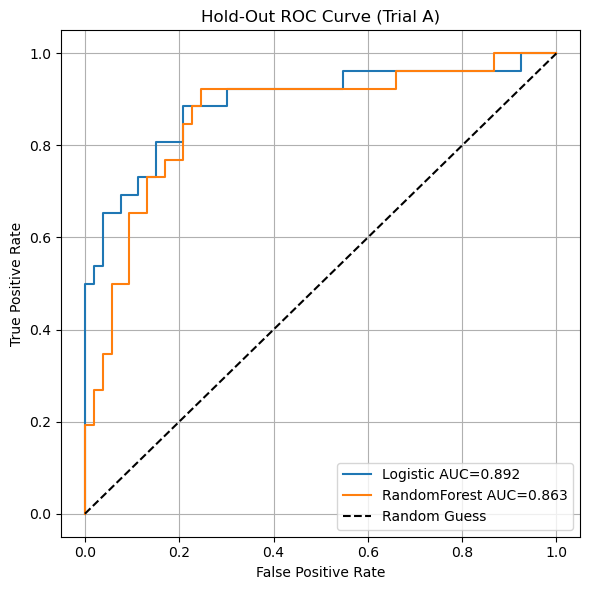

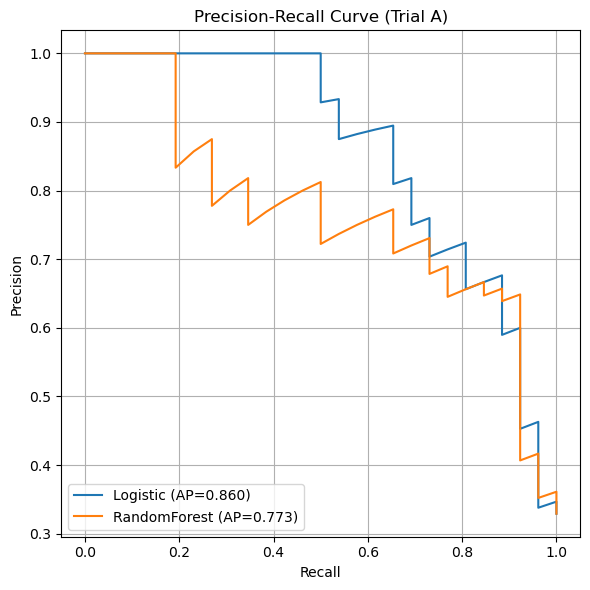

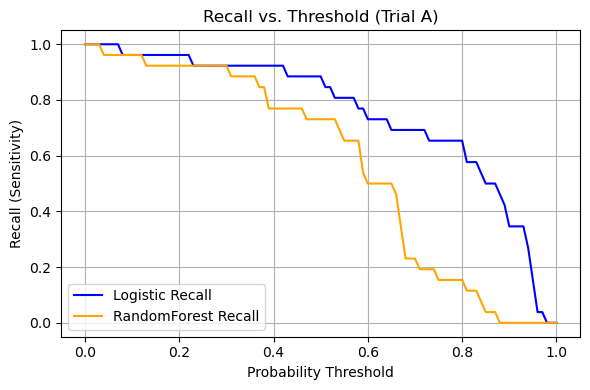

In [39]:
# Trial A Hold-out ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, probsA_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, probsA_rf)

plt.figure(figsize=(6,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic AUC={roc_auc_score(y_test,probsA_lr):.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest AUC={roc_auc_score(y_test,probsA_rf):.3f}')
plt.plot([0,1],[0,1],'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hold‑Out ROC Curve (Trial A)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Trial A Precision-Recall Curves and Average Precision
prec_lr, recall_lr, _ = precision_recall_curve(y_test, probsA_lr)
ap_lr = average_precision_score(y_test, probsA_lr)
prec_rf, recall_rf, _ = precision_recall_curve(y_test, probsA_rf)
ap_rf = average_precision_score(y_test, probsA_rf)

# Plot PR Curves
plt.figure(figsize=(6,6))
plt.plot(recall_lr, prec_lr, label=f'Logistic (AP={ap_lr:.3f})')
plt.plot(recall_rf, prec_rf, label=f'RandomForest (AP={ap_rf:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision‑Recall Curve (Trial A)')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot recall (sensitivity) as a function of probability threshold
t_thresholds = np.linspace(0,1,101)
recall_vals_lr = [recall_score(y_test, (probsA_lr >= t).astype(int)) for t in t_thresholds]
recall_vals_rf = [recall_score(y_test, (probsA_rf >= t).astype(int)) for t in t_thresholds]

plt.figure(figsize=(6,4))
plt.plot(t_thresholds, recall_vals_lr, label='Logistic Recall', color='blue')
plt.plot(t_thresholds, recall_vals_rf, label='RandomForest Recall', color='orange')
plt.xlabel('Probability Threshold')
plt.ylabel('Recall (Sensitivity)')
plt.title('Recall vs. Threshold (Trial A)')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Trial A (Drop-Zeros) Model Summary & Conclusions

1. **Cross-Validated Discrimination**  
   - Logistic Regression: mean AUC ≈ 0.85 ± 0.02  
   - Random Forest:   mean AUC ≈ 0.87 ± 0.02  
   ⇒ Both models separate diabetics from non-diabetics well, with RF edging out slightly in CV.

2. **Hold-Out Performance**  
   - **Logistic Regression**  
     - AUC = 0.892  
     - Accuracy = 0.823  
     - Sensitivity = 0.885  
     - Specificity = 0.792  
   - **Random Forest**  
     - AUC = 0.863  
     - Accuracy = 0.797  
     - Sensitivity = 0.731  
     - Specificity = 0.830  
   ⇒ On unseen data, Logistic excels at ranking (higher AUC) and catching true diabetics (88.5% recall), while RF is slightly better at avoiding false positives but misses more true cases.

3. **Precision–Recall Trade-off**  
   - **Average Precision**: Logistic ≈ 0.860 vs. RF ≈ 0.773  
   - At high recall levels (> 0.8), Logistic maintains precision around 0.6–0.7, whereas RF precision drops more sharply.  
   ⇒ Logistic offers a superior balance when you need to catch most diabetics without overwhelming false alarms.

4. **Sensitivity vs. Threshold**  
   - Logistic retains ≥ 80% recall all the way up to a 0.6 probability cutoff.  
   - RF falls below 80% recall by ~ 0.45 threshold.  
   ⇒ Logistic gives you more flexibility to raise the decision threshold (fewer false positives) while still identifying the majority of true cases.

---

### Final Recommendation

For the Drop-Zeros dataset (Trial A), **L1-regularized Logistic Regression** is the preferred model: it achieves the highest ROC-AUC, the greatest sensitivity on the hold-out set, and the best precision–recall balance. Its probability scores remain robust across a wide range of thresholds, making it both an accurate and reliable classifier for predicting type-2 diabetes in this cohort.  


### Trial C Tuned Model and ROC-AUC Curve

In [41]:
# Set up model to include best parameters

# Split dfC_filled
X = dfC_filled[feature_cols]
y = dfC_filled['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

bestC_lr = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
                C=0.1, 
                penalty='l1', 
                solver='liblinear',
                class_weight='balanced',
                random_state=0))
])

bestC_rf = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(
                n_estimators=100,
                max_depth=5,
                max_features='log2',
                class_weight='balanced',
                random_state=0))
])

# Fit on training data
bestC_lr.fit(X_train, y_train)
bestC_rf.fit(X_train, y_train)

# Predictions and Probabilities
probsC_lr = bestC_lr.predict_proba(X_test)[:,1]
probsC_rf = bestC_rf.predict_proba(X_test)[:,1]

# Compute metric
for name, probs in [('Logistic', probsC_lr), ('RandomForest', probsC_rf)]:
    auc = roc_auc_score(y_test, probs)
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(y_test, preds)
    sens = recall_score(y_test, preds)
    spec = recall_score(y_test, preds, pos_label=0)
    print(f"{name} @0.5 → AUC={auc:.3f}, Acc={acc:.3f}, Sens={sens:.3f}, Spec={spec:.3f}")

Logistic @0.5 → AUC=0.808, Acc=0.727, Sens=0.722, Spec=0.730
RandomForest @0.5 → AUC=0.816, Acc=0.747, Sens=0.741, Spec=0.750


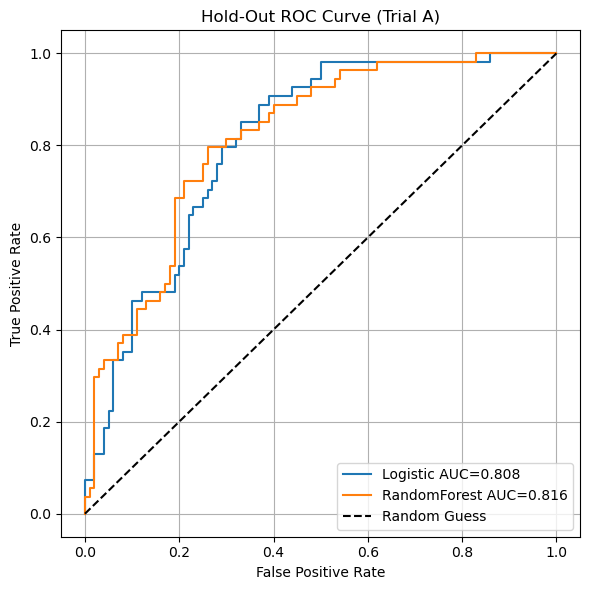

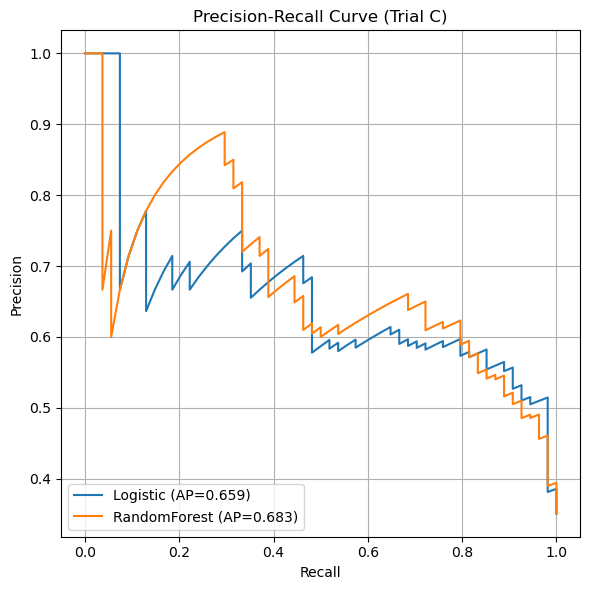

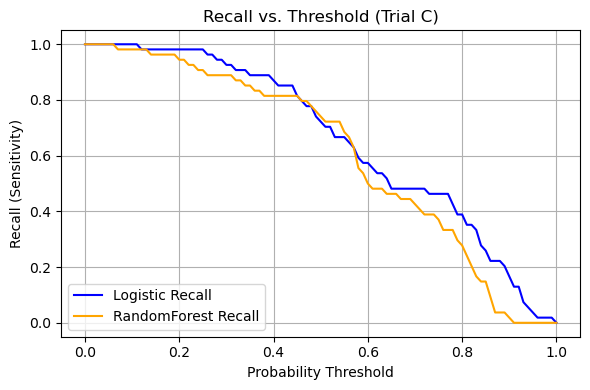

In [42]:
# Trial C Hold-out ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, probsC_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, probsC_rf)

plt.figure(figsize=(6,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic AUC={roc_auc_score(y_test,probsC_lr):.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest AUC={roc_auc_score(y_test,probsC_rf):.3f}')
plt.plot([0,1],[0,1],'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hold‑Out ROC Curve (Trial A)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Trial C Precision-Recall Curves and Average Precision
prec_lr, recall_lr, _ = precision_recall_curve(y_test, probsC_lr)
ap_lr = average_precision_score(y_test, probsC_lr)
prec_rf, recall_rf, _ = precision_recall_curve(y_test, probsC_rf)
ap_rf = average_precision_score(y_test, probsC_rf)

# Plot PR Curves
plt.figure(figsize=(6,6))
plt.plot(recall_lr, prec_lr, label=f'Logistic (AP={ap_lr:.3f})')
plt.plot(recall_rf, prec_rf, label=f'RandomForest (AP={ap_rf:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision‑Recall Curve (Trial C)')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot recall (sensitivity) as a function of probability threshold
t_thresholds = np.linspace(0,1,101)
recall_vals_lr = [recall_score(y_test, (probsC_lr >= t).astype(int)) for t in t_thresholds]
recall_vals_rf = [recall_score(y_test, (probsC_rf >= t).astype(int)) for t in t_thresholds]

plt.figure(figsize=(6,4))
plt.plot(t_thresholds, recall_vals_lr, label='Logistic Recall', color='blue')
plt.plot(t_thresholds, recall_vals_rf, label='RandomForest Recall', color='orange')
plt.xlabel('Probability Threshold')
plt.ylabel('Recall (Sensitivity)')
plt.title('Recall vs. Threshold (Trial C)')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Trial C (KNN-Imputation) Model Summary & Conclusions

1. **Hold-Out Performance**  
   - **Logistic Regression @0.5**  
     - AUC = 0.808  
     - Accuracy = 0.727  
     - Sensitivity = 0.722  
     - Specificity = 0.730  
   - **Random Forest @0.5**  
     - AUC = 0.816  
     - Accuracy = 0.747  
     - Sensitivity = 0.741  
     - Specificity = 0.750  
   > On the KNN-imputed Trial C data, Random Forest slightly outperforms Logistic Regression on every metric: it separates cases more cleanly (AUC), makes more correct predictions overall, and balances sensitivity/specificity more evenly.

2. **Precision–Recall Trade-off**  
   - **Average Precision**: Logistic ≈ 0.659 vs. RF ≈ 0.683  
   - The RF PR-curve (orange) sits above the Logistic curve (blue) across most recall levels, indicating it can achieve both higher precision and higher recall on this imputed dataset.

3. **Sensitivity vs. Threshold**  
   - Both models start at 100% recall at very low thresholds.  
   - **Logistic** retains >80% sensitivity up to t≈0.55, whereas  
   - **RF** holds >80% only up to t≈0.45.  
   > This means you can raise the decision cutoff higher with Logistic if you need fewer false positives, but RF will catch a few more true cases at lower thresholds.

---

### Recommendation

- **Random Forest** is the preferred classifier on the KNN-imputed dataset: it achieves the highest AUC, accuracy, and average precision.  
- **Logistic Regression** remains competitive with robust recall at stricter thresholds, making it a solid fallback if you need a simpler, more interpretable model.  

In our final deployment, we’ll compare the tuned Random Forest from Trial C against the tuned Logistic from Trial A (drop-zeros) and choose based on the best balance of performance, interpretability, and calibration.  
